### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 20:50 (МСК)

In [ ]:
#! pip install razdel

In [ ]:
#! pip install --user -U nltk

In [ ]:
#! pip install pymorphy2

### Переходим к практике

In [ ]:
import pandas as pd

Наши новости

In [ ]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

Загрузим пользователей и списки последних прочитанных новостей

In [ ]:
users = pd.read_csv("users_articles.csv")
users.head(3)

Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [ ]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
#import nltk
#nltk.download()

In [ ]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [ ]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [ ]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

А теперь в 3 строчки обучим нашу модель

In [93]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [94]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [95]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 36s


In [96]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [97]:
other_texts = [t for t in news['title'].iloc[:3]]
other_texts

[['заместитель',
  'председатель',
  'правительство',
  'рф',
  'сергей',
  'иванов',
  'избрать',
  'председатель',
  'совет',
  'пбк',
  'цска',
  'сообщать',
  'прессслужба',
  'армеец',
  'решение',
  'единогласно',
  'принять',
  'первый',
  'заседание',
  'совет',
  'клуб',
  'основной',
  'функция',
  'это',
  'орган',
  'обсуждение',
  'текущий',
  'состояние',
  'планирование',
  'утверждение',
  'стратегия',
  'развитие',
  'клуб',
  'близкий',
  'перспектива',
  'nn',
  'состав',
  'совет',
  'войти',
  'георгий',
  'полтавченко',
  'полномочный',
  'представитель',
  'президент',
  'центральный',
  'федеральный',
  'округ',
  'алексей',
  'седов',
  'генералполковник',
  'начальник',
  'служба',
  'защита',
  'конституционный',
  'строй',
  'борьба',
  'терроризм',
  'фсб',
  'рф',
  'nn',
  'александр',
  'новак',
  'заместитель',
  'министр',
  'финансы',
  'рф',
  'вячеслав',
  'полтавец',
  'заместитель',
  'генеральный',
  'директор',
  'руководитель',
  'блок',
  'вза

In [248]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.16163354),
 (3, 0.30618972),
 (5, 0.16534118),
 (16, 0.15844719),
 (18, 0.19048676)]

In [249]:
#tp[1] - because u get rid ofthe enumerator
#tp[0] - here u ad back the numerator to the words taken ount of the tuple
# the blue matrix

x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: это украина мочь который страна россия журнал
topic_1: австралийский австралия фараон вмф разнообразный попов обогнать
topic_2: фестиваль остров конкурс программа супруг включать состояться
topic_3: это который nn время свой день первый
topic_4: болезнь китай китайский страдать сократиться врач гагарин
topic_5: это год свой весь очень новый первый
topic_6: год который это проект день время nn
topic_7: это который россия год эксперт президент новый
topic_8: nn банк рф россия год государственный правительство
topic_9: это который год свой земля женщина мочь
topic_10: проверка университет nn студент озеро пища употребление
topic_11: белоруссия турецкий превысить белорусский мальчик визовый мастеркласс
topic_12: военный километр форум боевой год иран технология
topic_13: район пациент исследование армия фонд данные территория
topic_14: убийство дело расследование который обвинение следователь вирус
topic_15: сша компания год российский исследование рынок северный
topic_16: год чел

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [250]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i]) # appends the i[1] into the vector (values)
    return np.array(output_vector)

In [251]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.887155,...,0.0,0.000000,0.0,0.053340,0.0,0.0,0.0,0.000000,0.0,0.0
1,4896,0.000000,0.000000,0.0,0.749034,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.175320,0.0,0.0,0.0,0.000000,0.0,0.0
2,4897,0.163387,0.000000,0.0,0.304211,0.0,0.165125,0.0,0.0,0.000000,...,0.0,0.158758,0.0,0.190617,0.0,0.0,0.0,0.000000,0.0,0.0
3,4898,0.000000,0.012122,0.0,0.358890,0.0,0.334792,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.037381,0.0,0.0,0.0,0.125416,0.0,0.0
4,4899,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.412380,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [252]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [253]:
# values for doc_id are not necessary  but .values for the the topic are important
# with out .values u will get only the column names (topics_) and not the column values (array)
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [254]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.22940703, 0.        ,
       0.        , 0.26036733, 0.        , 0.        , 0.14373296,
       0.        , 0.        , 0.        , 0.05045778, 0.        ,
       0.17132093, 0.04612657, 0.03790533, 0.        , 0.        ,
       0.05036246, 0.        , 0.        , 0.        , 0.        ])

In [255]:
user_articles_list = users['articles'].iloc[33]
user_articles_list

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [256]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list]) #shows topics for each user by the id
    user_vector = np.mean(user_vector, 0) # user id is listed for each row, thats why mean is set for each row
    return user_vector

In [257]:
get_user_embedding(user_articles_list)

array([0.08715201, 0.        , 0.        , 0.02620312, 0.01081609,
       0.01647676, 0.11067692, 0.20065226, 0.06043116, 0.04363513,
       0.        , 0.        , 0.04171113, 0.03296349, 0.07562964,
       0.06367525, 0.02704339, 0.        , 0.        , 0.03438483,
       0.13086196, 0.00281822, 0.01850382, 0.        , 0.00399903])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [258]:
#users['articles'].iloc[33]

In [259]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [260]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.029593,0.0,0.012121,0.105118,0.000000,0.002357,0.181376,0.006787,0.090031,...,0.122755,0.122663,0.022196,0.006258,0.068343,0.023462,0.012576,0.014242,0.0,0.000000
1,u108690,0.123575,0.0,0.000000,0.149095,0.002826,0.039897,0.035291,0.157245,0.088926,...,0.020852,0.038159,0.002966,0.000000,0.057439,0.059300,0.001862,0.036438,0.0,0.003742
2,u108339,0.019322,0.0,0.000000,0.178111,0.011803,0.003779,0.123979,0.088060,0.125879,...,0.041133,0.075657,0.005398,0.000000,0.063466,0.061651,0.014329,0.013676,0.0,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [261]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [262]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.029593,0.0,0.012121,0.105118,0.000000,0.002357,0.181376,0.006787,0.090031,...,0.122663,0.022196,0.006258,0.068343,0.023462,0.012576,0.014242,0.0,0.000000,0
1,u108690,0.123575,0.0,0.000000,0.149095,0.002826,0.039897,0.035291,0.157245,0.088926,...,0.038159,0.002966,0.000000,0.057439,0.059300,0.001862,0.036438,0.0,0.003742,1
2,u108339,0.019322,0.0,0.000000,0.178111,0.011803,0.003779,0.123979,0.088060,0.125879,...,0.075657,0.005398,0.000000,0.063466,0.061651,0.014329,0.013676,0.0,0.000000,1


In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [264]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [265]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [266]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16434373, 0.16450603, 0.48236401, 0.18450275, 0.04917766,
       0.03735839, 0.10663646, 0.18034416, 0.04145298, 0.08929798])

In [267]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [268]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

mean_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]
mean_rating

Best Threshold=0.227853, F-Score=0.710, Precision=0.618, Recall=0.833


[0.7095652173913043,
 0.6181818181818182,
 0.8326530612244898,
 0.9589278446421304]

In [269]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1629  126]
 [  42  203]]


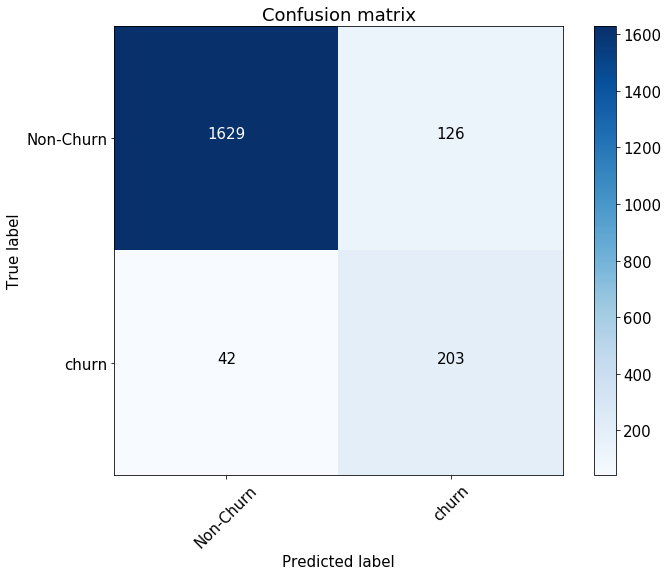

In [270]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [271]:
roc_auc_score(y_test, preds)

0.9589278446421304

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

#### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [272]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

array([0.0390613 , 0.        , 0.        , 0.        , 0.        ,
       0.02159904, 0.12218368, 0.1684129 , 0.01458124, 0.02747162,
       0.        , 0.        , 0.01391646, 0.02624733, 0.        ,
       0.04249145, 0.00901353, 0.        , 0.        , 0.        ,
       0.12980108, 0.        , 0.        , 0.        , 0.        ])

In [273]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.0,0.099661,0.0,0.000000,0.191227,0.000000,0.035977,...,0.046232,0.088396,0.018953,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,u108690,0.130155,0.0,0.0,0.127794,0.0,0.019092,0.031732,0.149640,0.059989,...,0.015948,0.005494,0.000000,0.0,0.059531,0.056781,0.0,0.0,0.0,0.0
2,u108339,0.005192,0.0,0.0,0.185240,0.0,0.000000,0.112067,0.082483,0.121969,...,0.000000,0.048896,0.000000,0.0,0.020654,0.072817,0.0,0.0,0.0,0.0


In [274]:
#target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [275]:
X = pd.merge(user_embeddings, target, how = 'left', on='uid')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.0,0.099661,0.0,0.000000,0.191227,0.000000,0.035977,...,0.088396,0.018953,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
1,u108690,0.130155,0.0,0.0,0.127794,0.0,0.019092,0.031732,0.149640,0.059989,...,0.005494,0.000000,0.0,0.059531,0.056781,0.0,0.0,0.0,0.0,1
2,u108339,0.005192,0.0,0.0,0.185240,0.0,0.000000,0.112067,0.082483,0.121969,...,0.048896,0.000000,0.0,0.020654,0.072817,0.0,0.0,0.0,0.0,1


In [276]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

median_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]
median_rating

Best Threshold=0.275043, F-Score=0.841, Precision=0.808, Recall=0.878


[0.8414872798434442, 0.8082706766917294, 0.8775510204081632, 0.985103785103785]

Confusion matrix, without normalization
[[1704   51]
 [  31  214]]


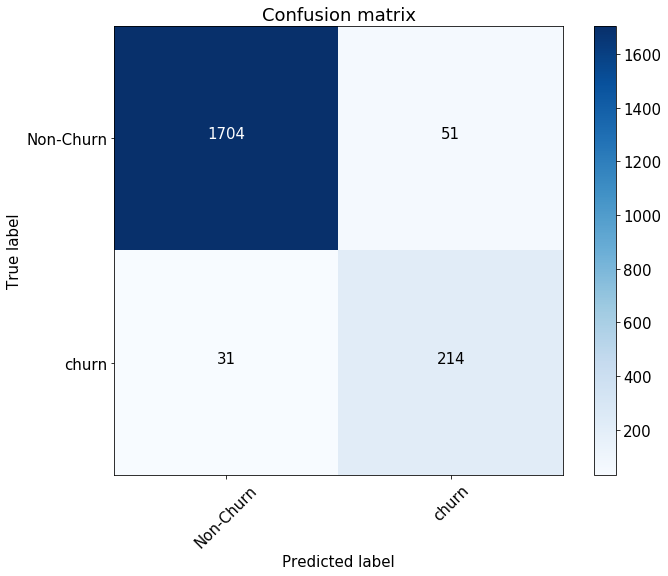

In [277]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [278]:
roc_auc_score(y_test, preds)

0.985103785103785

#### 3. Повторить п.2, но используя уже не медиану, а max

In [236]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

array([0.23386221, 0.        , 0.        , 0.10372041, 0.06489677,
       0.03081285, 0.21240409, 0.48273402, 0.16936085, 0.14607434,
       0.        , 0.        , 0.15547748, 0.09198186, 0.45376351,
       0.20352244, 0.09315585, 0.        , 0.        , 0.13003726,
       0.30280641, 0.01690889, 0.11103561, 0.        , 0.02399414])

In [237]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.115214,0.0,0.072709,0.229520,0.000000,0.014142,0.396907,0.040625,0.360771,...,0.472777,0.403640,0.050973,0.037548,0.326435,0.090409,0.060886,0.085477,0.0,0.000000
1,u108690,0.212325,0.0,0.000000,0.280423,0.016945,0.103869,0.104355,0.387394,0.229611,...,0.054133,0.149118,0.017798,0.000000,0.094046,0.125502,0.011117,0.143350,0.0,0.011582
2,u108339,0.058791,0.0,0.000000,0.299387,0.070812,0.022672,0.230984,0.213703,0.198922,...,0.167879,0.225822,0.019460,0.000000,0.195480,0.098608,0.061805,0.082057,0.0,0.000000


In [238]:
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [239]:
X = pd.merge(user_embeddings, target, how = 'left', on='uid')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.115214,0.0,0.072709,0.229520,0.000000,0.014142,0.396907,0.040625,0.360771,...,0.403640,0.050973,0.037548,0.326435,0.090409,0.060886,0.085477,0.0,0.000000,0
1,u108690,0.212325,0.0,0.000000,0.280423,0.016945,0.103869,0.104355,0.387394,0.229611,...,0.149118,0.017798,0.000000,0.094046,0.125502,0.011117,0.143350,0.0,0.011582,1
2,u108339,0.058791,0.0,0.000000,0.299387,0.070812,0.022672,0.230984,0.213703,0.198922,...,0.225822,0.019460,0.000000,0.195480,0.098608,0.061805,0.082057,0.0,0.000000,1


In [240]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

max_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]
max_rating

Best Threshold=0.347935, F-Score=0.772, Precision=0.764, Recall=0.780


[0.7717171717171718, 0.764, 0.7795918367346939, 0.9719890691319263]

Confusion matrix, without normalization
[[1696   59]
 [  55  190]]


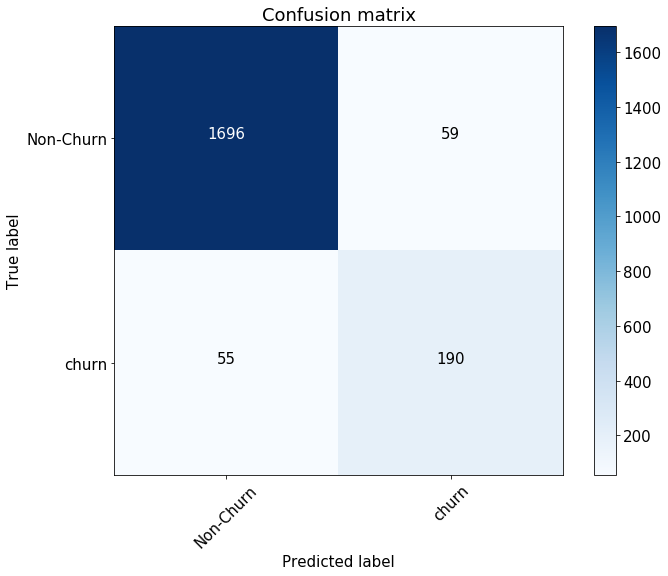

In [241]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [204]:
roc_auc_score(y_test, preds) 

0.9719890691319263

### Вопрос: У меня низкая F-score но высоквя ROC-AUC, можно ли считать мои выводы качественными, либо надо еще поработать с данными ?

#### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [282]:
table = {'mean': mean_rating,
         'median': median_rating,
         'max': max_rating}

table= pd.DataFrame(table, index = ['F1_score', 'Rrecision', 'Recall', 'Roc Auc'] )
table.T

,F1_score,Rrecision,Recall,Roc Auc
mean,0.709565,0.618182,0.832653,0.958928
median,0.841487,0.808271,0.877551,0.985104
max,0.771717,0.764000,0.779592,0.971989


In [279]:
mean_rating

[0.7095652173913043,
 0.6181818181818182,
 0.8326530612244898,
 0.9589278446421304]

In [280]:
median_rating

[0.8414872798434442, 0.8082706766917294, 0.8775510204081632, 0.985103785103785]

In [283]:
max_rating

[0.7717171717171718, 0.764, 0.7795918367346939, 0.9719890691319263]

* max и median показали себя лучше mean так как mean получает нечто среднее из тематик всех статей, в итоге размывает значения 
* выбранные значения в median и max имеют больший вес чем в mean